In [11]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Make UV plots and calculate synthesized beams for the VLA

### a) Plot the 2D positions of the antennas

In [12]:
pos_a = np.loadtxt('vla_a_array.txt')[:,:3]
pos_d = np.loadtxt('vla_d_array.txt')[:,:3]

The following is adapted from Jon's `interferometer_uv.py`. I know we aren't supposed to use Jon's code, but I've been really struggling to understand a lot of these ideas (I have never worked with radio telescopes before), so the best I could do here was adapt it

In [635]:
def plot_arr(pos,config,plot=True):
    lat=34.0784*np.pi/180
    
    if config == 'a':
        du = 40.0
    if config == 'd':
        du = 2.0

    #convert to m from light-nanoseconds
    pos_m = pos*1e-9*3e8

    #convert to 2D coordinates
    zenith=np.asarray([np.cos(lat),0,np.sin(lat)])
    east=np.asarray([0,1,0])
    north=np.cross(zenith,east)
    mat=np.vstack([north,east,zenith])
    xyz=pos_m@mat.T
    
    #rms scatter
    vert_rms = np.std(pos[2])

    print(f'Vertical scatter: {vert_rms} m')

    
    if plot:
        plt.plot(xyz[:,1],xyz[:,0],'o')
        plt.ylabel('N/S')
        plt.xlabel('E/W')
        plt.show()
        return xyz,mat
    
    return xyz

Vertical scatter: 5073.423159106242 m


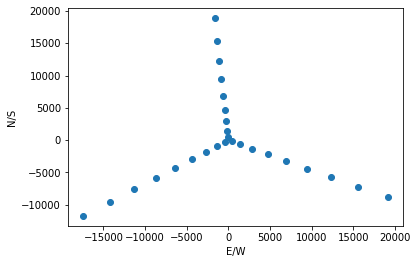

Vertical scatter: 143.7134791482305 m


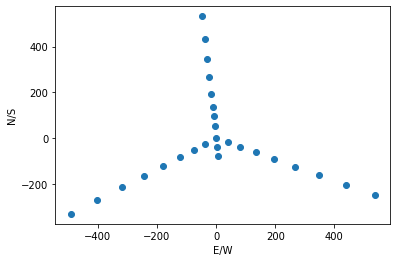

In [636]:
xyz_a = plot_arr(pos_a,'a')
xyz_d = plot_arr(pos_d,'d')

We can see that the vertical/horizontal spread of the A array is ~35 000 m and the D array spread is ~1000 m, whereas the scatter in vertical spread is << smaller than this for both arrays

### b) Make UV plots for both configurations

u = EW baseline, v = NS baseline

In [374]:
def get_uv(pos,freq):
    u = np.array(())
    v = np.array(())
    wl = 3e8/freq
    for i in range(len(pos)):
        for j in range(i+1,len(pos)):
            u = np.append(u,(pos[i,0]-pos[j,0])/wl)
            u = np.append(u,-(pos[i,0]-pos[j,0])/wl)

            v = np.append(v,(pos[i,1]-pos[j,1])/wl)
            v = np.append(v,-(pos[i,1]-pos[j,1])/wl)
    return u,v

Text(0.5, 1.0, 'A array configuration')

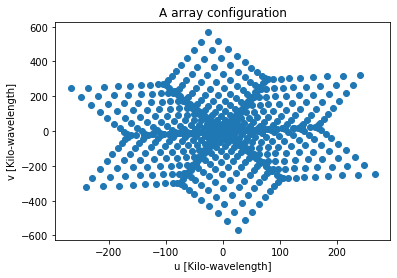

In [375]:
u_a,v_a = get_uv(pos_a,1.4e9)
plt.plot(u_a/1000,v_a/1000,'o')
plt.ylabel('v [Kilo-wavelength]')
plt.xlabel('u [Kilo-wavelength]')
plt.title('A array configuration')

Text(0.5, 1.0, 'D array configuration')

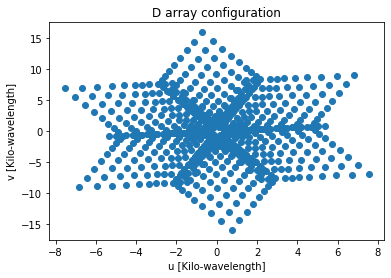

In [376]:
u_d,v_d = get_uv(pos_d,1.4e9)
plt.plot(u_d/1000,v_d/1000,'o')
plt.ylabel('v [Kilo-wavelength]')
plt.xlabel('u [Kilo-wavelength]')
plt.title('D array configuration')

### c) Plot the dirty beam based on the UV coverage from b)

In [377]:
uv_a = np.zeros([len(u_a),2])
uv_d = np.zeros([len(u_d),2])
for i in range(len(uv_a)):
    uv_a[i,:]=np.array([u_a[i],v_a[i]])
    uv_d[i,:]=np.array([u_d[i],v_d[i]])

In [378]:
from tqdm import tqdm
def dirty_beam(uv,proj,du,freq=1.4e9):
    sz=int(np.max(np.abs(uv))/du)
    uv_mat=np.zeros([sz+1,sz+1])
    uv = uv@proj
    uv_int=np.asarray(uv/du,dtype='int')
    for i in tqdm(range(uv_int.shape[0])):
        uv_mat[uv_int[i,0],uv_int[i,1]]=uv_mat[uv_int[i,0],uv_int[i,1]]+1
    beam=np.abs(np.fft.ifft2(uv_mat))
    
    return beam

100%|██████████| 702/702 [00:00<00:00, 176872.79it/s]


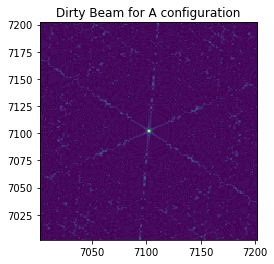

In [736]:
lat=34.0784*np.pi/180
zenith=np.asarray([np.cos(lat),0,np.sin(lat)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)

proj_mat=np.vstack([east,north])

beam_a = dirty_beam(uv_a,proj_mat,40.0)
plt.title('Dirty Beam for A configuration')
plt.imshow(np.fft.fftshift(beam_a))
x0=beam_a.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

100%|██████████| 702/702 [00:00<00:00, 147014.25it/s]


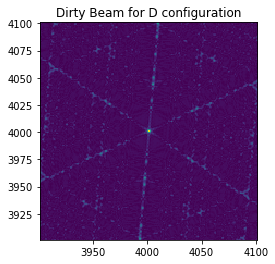

In [737]:
beam_d = dirty_beam(uv_d,proj_mat,2.0)
plt.title('Dirty Beam for D configuration')
plt.imshow(np.fft.fftshift(beam_d))
x0=beam_d.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

#### Let's now normalize these to get this in RA + DEC coordinates

Get FWHM by fitting a 1D Gaussian to the beam

In [716]:
#A array
beam_fit=np.fft.fftshift(beam_a)
max_pos=np.unravel_index(beam_fit.argmax(), beam_fit.shape)

(7096, 7107)

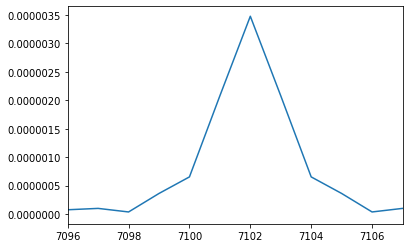

In [721]:
plt.plot(beam_fit[max_pos[0]])
plt.xlim(7096,7107)

Normally to get FWHM, I would fit a Gaussian to this (see beginning of attempt below), but I don't have enough time to do this,normalize,etc., so I'll just estimate it to be ~2 (i.e., 7103-7101). This is equivalent to our FOV

In [729]:
# D array

beam_fit=np.fft.fftshift(beam_d)
max_pos=np.unravel_index(beam_fit.argmax(), beam_fit.shape)

(3995, 4005)

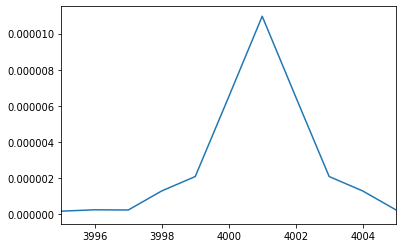

In [733]:
plt.plot(beam_fit[max_pos[0]])
plt.xlim(3995,4005)

FWHM for D array is also ~2

In [704]:
def gauss(x,amp,mu,sigma):
    return amp*np.exp(-0.5*(x-mu)**2/sigma**2)

In [ ]:
from scipy.optimize import curve_fit

x = np.linspace(len(beam_fit[max_pos[0]]))
popt,pcov = curve_fit(gauss,x,beam_fit[max_pos[0]],[])

In [722]:
npix = 4096 #from Jon's code
fov = 2 #estimated fwhm
resolution = fov/npix
resolution = np.deg2rad(resolution)*3600 #convert to arcsec
print(f'Resolution: {resolution}"')

Resolution: 0.030679615757712823"


Resolution means 1 pixel is 0.038" $\Rightarrow$ we can use this to normalize our beams and get them in units of arcsec, with the centre at 0, since the source is overhead

I could not figure out how to actually implement this in my plots, sorry!

TypeError: object of type 'NoneType' has no len()

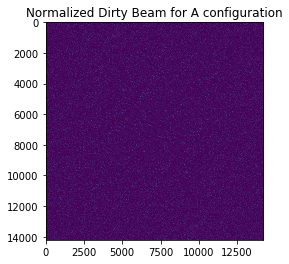

In [739]:
plt.title('Normalized Dirty Beam for A configuration')
plt.imshow(np.fft.fftshift(beam_a))
plt.xticks(labels=resolution*beam_a[0])
plt.yticks(labels=resolution*beam_a[1])
x0=beam_a.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])

In [ ]:
beam_d = beam_d*resolution
plt.title('Normalized Dirty Beam for D configuration')
plt.imshow(np.fft.fftshift(beam_d))
x0=beam_d.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])

### d) Repeat the UV plots, but now assuming you observe a source for 8 hours, starting 4 hours before the source transits overhead, to 4 hours after

I tried this with just the 2D UV arrays and this didn't work, so I'm introducing 3D a little earlier than the PS suggests and then plotting only the 2D component

I'll also be plotting:

### e) Plots the synthesized beams for the cases in d)

My beams don't really look like the ones on Jon's slides, especially the equator beam, which is still supposed to look like a dot with some star-shaped diffraction patterns, but mine looks like a big smear

In [547]:
def get_uvw(pos,freq):
    u = np.array(())
    v = np.array(())
    w = np.array(())
    wl = 3e8/freq
    for i in range(len(pos)):
        for j in range(i+1,len(pos)):
            u = np.append(u,(pos[i,0]-pos[j,0])/wl)
            u = np.append(u,-(pos[i,0]-pos[j,0])/wl)
            v = np.append(v,(pos[i,1]-pos[j,1])/wl)
            v = np.append(v,-(pos[i,1]-pos[j,1])/wl)
            w = np.append(w,(pos[i,2]-pos[j,2])/wl)
            w = np.append(w,-(pos[i,2]-pos[j,2])/wl)
    return u,v,w

In [550]:
u_a,v_a,w_a = get_uvw(pos_a,1.4e9)
u_d,v_d,w_d = get_uvw(pos_d,1.4e9)

uvw_a = np.zeros([len(u_a),3])
uvw_d = np.zeros([len(u_d),3])

for i in range(len(uv_a)):
    uvw_a[i,:]=np.array([u_a[i],v_a[i],w_a[i]])
    uvw_d[i,:]=np.array([u_d[i],v_d[i],w_d[i]])

#### Function to rotate UV coordinates with the Earth

I hardcoded in times from 4h before overhead to 4h after overhead (60 total measurements, as in Jon's code) and translated this into a range of angles that the source will pass through as it transits

Then, for each value of $\theta$, I multiply the 3D uvw positions by rotation matrix:

$\begin{bmatrix}
cos\theta & -sin\theta & 0\\
sin \theta & cos \theta & 0\\
0 & 0 & 1
\end{bmatrix}$

And multiply by the projection matrix, which takes into account the source's declination.

In [556]:
def rotated_uv(uv,proj,freq=1.4e9,du=40.0):
    
    t_range=np.linspace(-4,4,61)
    theta_range=t_range*2*np.pi/24
            
    for theta in theta_range:
        c, s = np.cos(theta), np.sin(theta)
        rot_mat = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
        uv_rot = uv@rot_mat
        uv_proj = uv_rot@proj_mat.T
        
        plt.plot(uv_proj[:,0],uv_proj[:,1],'go')

#### Overhead Source

In 3D coordinates, $\delta$ = latitude = 34.0784 degrees = 0.59 rad

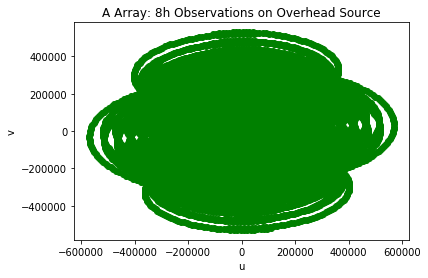

100%|██████████| 702/702 [00:00<00:00, 105360.39it/s]


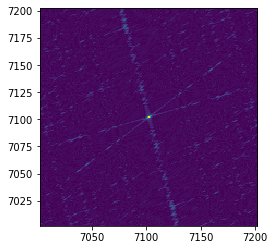

In [580]:
#A configuration

dec=lat #since source is directly overhead
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_a,proj_mat)
plt.title('A Array: 8h Observations on Overhead Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_a,proj_mat,40.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

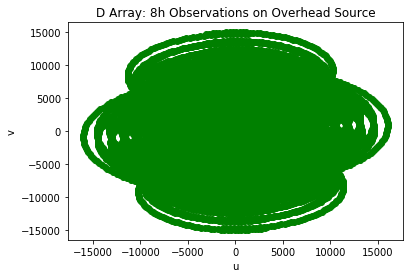

100%|██████████| 702/702 [00:00<00:00, 322462.10it/s]


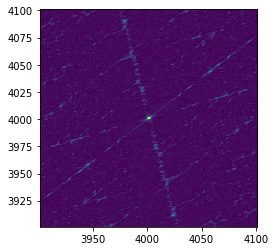

In [581]:
#D configuration

dec=lat #since source is directly overhead
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_d,proj_mat)
plt.title('D Array: 8h Observations on Overhead Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_d,proj_mat,2.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

#### Source at North Celestial Pole

$\delta = \pi/2$

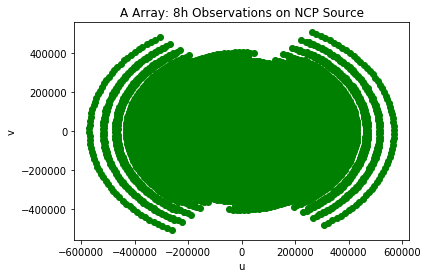

100%|██████████| 702/702 [00:00<00:00, 659735.92it/s]


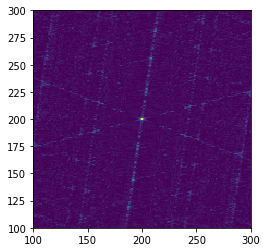

In [582]:
#A configuration

dec=np.pi/2 #since source is at NCP
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_a,proj_mat)
plt.title('A Array: 8h Observations on NCP Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_d,proj_mat,40.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

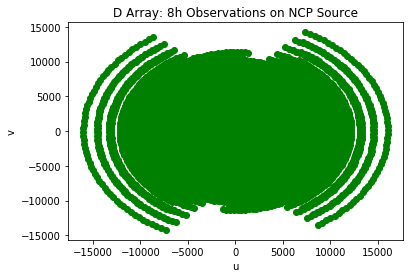

100%|██████████| 702/702 [00:00<00:00, 317318.83it/s]


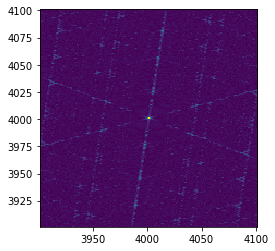

In [583]:
#D configuration

dec=np.pi/2 #since source is at NCP
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_d,proj_mat)
plt.title('D Array: 8h Observations on NCP Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_d,proj_mat,2.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

#### Equator

$\delta = 0$

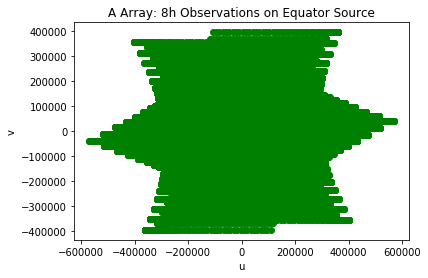

100%|██████████| 702/702 [00:00<00:00, 661514.58it/s]


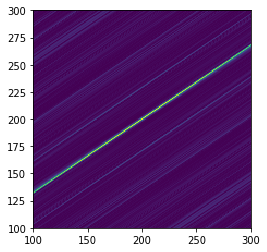

In [584]:
#A configuration

dec=0 #since source is at equator
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_a,proj_mat)
plt.title('A Array: 8h Observations on Equator Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_d,proj_mat,40.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

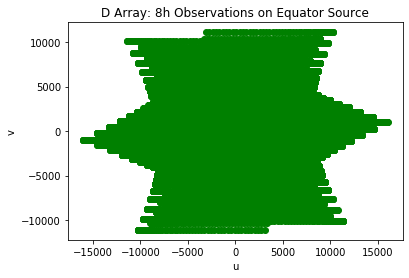

100%|██████████| 702/702 [00:00<00:00, 328323.08it/s]


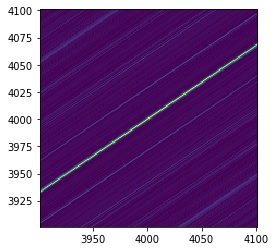

In [585]:
#D configuration

dec=0 #since source is at equator
zenith=np.asarray([np.cos(dec),0,np.sin(dec)])
east=np.asarray([0,1,0])
north=np.cross(zenith,east)
proj_mat=np.vstack([east,north,zenith])

rotated_uv(uvw_d,proj_mat)
plt.title('D Array: 8h Observations on Equator Source')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

beam = dirty_beam(uvw_d,proj_mat,2.0)
plt.imshow(np.fft.fftshift(beam))
x0=beam.shape[0]//2
dx=100
plt.xlim([x0-dx,x0+dx])
plt.ylim([x0-dx,x0+dx])
plt.show()

# 2. w-term

### a) Estimate the FOV of the VLA at 1.4 GHz and 8 GHz

From the VLA website: https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/fov

"An approximate formula for the full width at half power in arcminutes is $θ_{PB} = \frac{42}{ν_{GHz}}$ for frequencies between 1 and 50 GHz (L- through Q-band)"

$\Rightarrow for\ 1.4\ GHz: θ_{PB} = \frac{42}{1.4} = 30'$

$\Rightarrow for\ 8\ GHz: θ_{PB} = \frac{42}{8} = 5.25'$

### b) For a source directly overhead, calculate the difference in distance for each baseline for the overhead source and a source 30 arcminutes to the south

In [604]:
def get_theta_vec(theta):
    return np.array([0,np.sin(theta),np.cos(theta)])

def array_diffs2D(theta1,theta2,uv,two=True):
    if two:
        theta_vec1 = get_theta_vec(theta1)[:2] #only use first 2 terms, since this is 2D
        theta_vec2 = get_theta_vec(theta2)[:2]
    else:
        theta_vec1 = get_theta_vec(theta1) 
        theta_vec2 = get_theta_vec(theta2)
        
    dist_overhead1 = np.dot(theta_vec1,uv)
    dist_overhead2 = np.dot(theta_vec2,uv)

    diff = dist_overhead2-dist_overhead1
    
    return np.sqrt(np.mean(diff**2)) #RMS difference

In [590]:
uv_a_1d4 = get_uv(pos_a,1.4e9)
uv_d_1d4 = get_uv(pos_d,1.4e9)

uv_a_8 = get_uv(pos_a,8e9)
uv_d_8 = get_uv(pos_d,8e9)

#### 1.4 GHz
Source at 30' to the South: $\theta = 30' S = - 0.5^\circ$

In [616]:
rms_diff_a_2D = array_diffs2D(0,np.deg2rad(-0.5),uv_a_1d4)
rms_diff_d_2D = array_diffs2D(0,np.deg2rad(-0.5),uv_d_1d4)

print('A Array RMS Difference',rms_diff_a_2D, 'm')
print('D Array RMS Difference',rms_diff_d_2D, 'm')

A Array RMS Difference 1559.873628125517 m
D Array RMS Difference 43.97411619524901 m


#### 8 GHz

In [617]:
rms_diff_a_8_2D = array_diffs2D(0,np.deg2rad(-0.5),uv_a_8)
rms_diff_d_8_2D = array_diffs2D(0,np.deg2rad(-0.5),uv_d_8)

print('A Array RMS Difference',rms_diff_a_8_2D, 'm')
print('D Array RMS Difference',rms_diff_d_8_2D, 'm')

A Array RMS Difference 8913.563589288668 m
D Array RMS Difference 251.2806639728515 m


### c) Now repeat but using the full 3D antenna positions. What is the RMS difference between these path length differences and the differences you calculated in b)?

Function to get 3D u,v,w array:

In [608]:
def get_uvw(pos,freq):
    u = np.array(())
    v = np.array(())
    w = np.array(())
    wl = 3e8/freq
    for i in range(len(pos)):
        for j in range(i+1,len(pos)):
            u = np.append(u,(pos[i,0]-pos[j,0])/wl)
            u = np.append(u,-(pos[i,0]-pos[j,0])/wl)
            v = np.append(v,(pos[i,1]-pos[j,1])/wl)
            v = np.append(v,-(pos[i,1]-pos[j,1])/wl)
            w = np.append(w,(pos[i,2]-pos[j,2])/wl)
            w = np.append(w,-(pos[i,2]-pos[j,2])/wl)
    return u,v,w

In [611]:
u_a,v_a,w_a = get_uvw(pos_a,1.4e9)
u_d,v_d,w_d = get_uvw(pos_d,1.4e9)

uvw_a_1d4 = np.zeros([len(u_a),3])
uvw_d_1d4 = np.zeros([len(u_d),3])

for i in range(len(uv_a)):
    uvw_a_1d4[i,:]=np.array([u_a[i],v_a[i],w_a[i]])
    uvw_d_1d4[i,:]=np.array([u_d[i],v_d[i],w_d[i]])

In [612]:
u_a,v_a,w_a = get_uvw(pos_a,8e9)
u_d,v_d,w_d = get_uvw(pos_d,8e9)

uvw_a_8 = np.zeros([len(u_a),3])
uvw_d_8 = np.zeros([len(u_d),3])

for i in range(len(uv_a)):
    uvw_a_8[i,:]=np.array([u_a[i],v_a[i],w_a[i]])
    uvw_d_8[i,:]=np.array([u_d[i],v_d[i],w_d[i]])

#### 1.4 GHz

In [614]:
theta1 = np.deg2rad(90-34.1)
theta2 = np.deg2rad(90-33.6) #half a degree away

rms_diff_a = array_diffs2D(theta1,theta2,uvw_a_1d4.T,two=False)
rms_diff_d = array_diffs2D(theta1,theta2,uvw_d_1d4.T,two=False)

print('A Array RMS Difference',rms_diff_a, 'm')
print('D Array RMS Difference',rms_diff_d, 'm')

A Array RMS Difference 1312.7301444001655 m
D Array RMS Difference 37.17186198604584 m


#### 8 GHz

In [624]:
theta1 = np.deg2rad(90-34.1)
theta2 = np.deg2rad(90-33.6) #half a degree away

rms_diff_a_8 = array_diffs2D(theta1,theta2,uvw_a_8.T,two=False)
rms_diff_d_8 = array_diffs2D(theta1,theta2,uvw_d_8.T,two=False)

print('A Array RMS Difference',rms_diff_a_8, 'm')
print('D Array RMS Difference',rms_diff_d_8, 'm')

A Array RMS Difference 7501.315110858089 m
D Array RMS Difference 212.41063992026199 m


#### Difference between differences

See below that this is >> $\lambda = c/\nu = c/1.4e9 = 0.21 m$ or $c/8e9 = 0.0375 m$, so we can't neglect the w term 

In [623]:
diff_diff_a = np.sqrt(np.mean((rms_diff_a - rms_diff_a_2D)**2))
diff_diff_d = np.sqrt(np.mean((rms_diff_d - rms_diff_d_2D)**2))

diff_diff_a_8 = np.sqrt(np.mean((rms_diff_a_8 - rms_diff_a_8_2D)**2))
diff_diff_d_8 = np.sqrt(np.mean((rms_diff_d_8 - rms_diff_d_8_2D)**2))

print("At 1.4 GHz")
print(f'Difference of A array differences: {diff_diff_a} m')
print(f'Difference of D array differences: {diff_diff_d} m')

print("At 8 GHz")
print(f'Difference of A array differences: {diff_diff_a_8} m')
print(f'Difference of D array differences: {diff_diff_d_8} m')

At 1.4 GHz
Difference of A array differences: 5941.441482732572 m
Difference of D array differences: 168.436523725013 m
At 8 GHz
Difference of A array differences: 1412.2484784305789 m
Difference of D array differences: 38.870024052589514 m


### d) Report the RMS phase difference for a source 1 FWHM from the pointing center at both 1.4 and 8 GHz

#### Pointing center directly overhead

Phase difference: $\Delta \phi = \frac{2 \pi \nu \Delta l}{c}$, where $\Delta l$ is the path length difference

$1\ FWHM = FOV = 30'$ for $1.4$ GHz and $5.25'$ for $8$ GHz

We can see that this effect is most important for pointing at the equator at 1.4 GHz, where the phase differs by ~0.02 rad compared to overhead sources, whereas at 8 GHz it doesn't vary much depending on source location $\therefore$ this is when we need to worry about the $w$ term.

In [627]:
theta = (90-34.1)*np.pi/180 
theta_vec = get_theta_vec(theta)

#find path length differences for 1.4 GHz
dist_a_overhead = np.dot(theta_vec,uvw_a_1d4.T)
dist_d_overhead = np.dot(theta_vec,uvw_d_1d4.T)

theta_fwhm = (90-33.6)*np.pi/180 
theta_vec_fwhm = get_theta_vec(theta_fwhm)

dist_a_fwhm = np.dot(theta_vec_fwhm,uvw_a_1d4.T)
dist_d_fwhm = np.dot(theta_vec_fwhm,uvw_d_1d4.T)

del_l_a = dist_a_overhead-dist_a_fwhm
del_l_d = dist_d_overhead-dist_d_fwhm

del_phi_a = (2*np.pi*del_l_a*1.4e9/3e8)%(2*np.pi)
del_phi_d = (2*np.pi*del_l_d*1.4e9/3e8)%(2*np.pi)

print(f'A Configuration Phase Difference for overhead pointing centre, 1.4 GHz: {np.sqrt(np.mean(del_phi_a**2))} rad')
print(f'D Configuration Phase Difference for overhead pointing centre, 1.4 GHz: {np.sqrt(np.mean(del_phi_d**2))} rad')

A Configuration Phase Difference for overhead pointing centre, 1.4 GHz: 3.611338107782114 rad
D Configuration Phase Difference for overhead pointing centre, 1.4 GHz: 3.613554114746774 rad


In [628]:
theta = (90-34.1)*np.pi/180 
theta_vec = get_theta_vec(theta)

#find path length differences for 1.4 GHz
dist_a_overhead = np.dot(theta_vec,uvw_a_8.T)
dist_d_overhead = np.dot(theta_vec,uvw_d_8.T)

theta_fwhm = (90-33.6)*np.pi/180 
theta_vec_fwhm = get_theta_vec(theta_fwhm)

dist_a_fwhm = np.dot(theta_vec_fwhm,uvw_a_8.T)
dist_d_fwhm = np.dot(theta_vec_fwhm,uvw_d_8.T)

del_l_a = dist_a_overhead-dist_a_fwhm
del_l_d = dist_d_overhead-dist_d_fwhm

del_phi_a = (2*np.pi*del_l_a*8e9/3e8)%(2*np.pi)
del_phi_d = (2*np.pi*del_l_d*8e9/3e8)%(2*np.pi)

print(f'A Configuration Phase Difference for overhead pointing centre, 8 GHz: {np.sqrt(np.mean(del_phi_a**2))} rad')
print(f'D Configuration Phase Difference for overhead pointing centre, 8 GHz: {np.sqrt(np.mean(del_phi_d**2))} rad')

A Configuration Phase Difference for overhead pointing centre, 8 GHz: 3.609286821394982 rad
D Configuration Phase Difference for overhead pointing centre, 8 GHz: 3.6234200173144107 rad


#### Pointing centre at equator

In [629]:
theta = (90)*np.pi/180 
theta_vec = get_theta_vec(theta)

#find path length differences for 1.4 GHz
dist_a_overhead = np.dot(theta_vec,uvw_a_1d4.T)
dist_d_overhead = np.dot(theta_vec,uvw_d_1d4.T)

theta_fwhm = (90-0.5)*np.pi/180 
theta_vec_fwhm = get_theta_vec(theta_fwhm)

dist_a_fwhm = np.dot(theta_vec_fwhm,uvw_a_1d4.T)
dist_d_fwhm = np.dot(theta_vec_fwhm,uvw_d_1d4.T)

del_l_a = dist_a_overhead-dist_a_fwhm
del_l_d = dist_d_overhead-dist_d_fwhm

del_phi_a = (2*np.pi*del_l_a*1.4e9/3e8)%(2*np.pi)
del_phi_d = (2*np.pi*del_l_d*1.4e9/3e8)%(2*np.pi)

print(f'A Configuration Phase Difference for equator pointing centre, 1.4 GHz: {np.sqrt(np.mean(del_phi_a**2))} rad')
print(f'D Configuration Phase Difference for equator pointing centre, 1.4 GHz: {np.sqrt(np.mean(del_phi_d**2))} rad')

A Configuration Phase Difference for equator pointing centre, 1.4 GHz: 3.634324822197017 rad
D Configuration Phase Difference for equator pointing centre, 1.4 GHz: 3.648518065213411 rad


In [630]:
theta = (90-34.1)*np.pi/180 
theta_vec = get_theta_vec(theta)

#find path length differences for 1.4 GHz
dist_a_overhead = np.dot(theta_vec,uvw_a_8.T)
dist_d_overhead = np.dot(theta_vec,uvw_d_8.T)

theta_fwhm = (90-0.5)*np.pi/180 
theta_vec_fwhm = get_theta_vec(theta_fwhm)

dist_a_fwhm = np.dot(theta_vec_fwhm,uvw_a_8.T)
dist_d_fwhm = np.dot(theta_vec_fwhm,uvw_d_8.T)

del_l_a = dist_a_overhead-dist_a_fwhm
del_l_d = dist_d_overhead-dist_d_fwhm

del_phi_a = (2*np.pi*del_l_a*8e9/3e8)%(2*np.pi)
del_phi_d = (2*np.pi*del_l_d*8e9/3e8)%(2*np.pi)

print(f'A Configuration Phase Difference for equator pointing centre, 8 GHz: {np.sqrt(np.mean(del_phi_a**2))} rad')
print(f'D Configuration Phase Difference for equator pointing centre, 8 GHz: {np.sqrt(np.mean(del_phi_d**2))} rad')

A Configuration Phase Difference for equator pointing centre, 8 GHz: 3.60469682274009 rad
D Configuration Phase Difference for equator pointing centre, 8 GHz: 3.6061172429307926 rad


# 3. By how much do we need to shift the frequency to make the RMS path length difference change by λ/2π for both A and D-arrays?

Let path difference = $x$ and phase = $\phi$

$\phi = u \theta = 2 \pi x = \frac{2 \pi}{\lambda} B \theta$ (as we saw in question 2) where $B \theta$ is a dot product

$\Rightarrow \Delta \phi = \frac{2 \pi}{\Delta \lambda} B \theta$

We know that $x = \frac{B \theta}{\lambda} \Rightarrow \Delta x = \frac{B \theta}{\Delta \lambda}$

$\Rightarrow \Delta \phi = 2 \pi \Delta x$

For an RMS path length difference change of $\lambda/2 \pi$, $RMS(\Delta x) = \frac{\lambda}{2 \pi} \Rightarrow \frac{RMS(B \theta)}{\Delta \lambda} = \frac{1}{2 \pi} $

Convert back to frequency (because we want shift in $\nu$!):

$\Delta \lambda = \frac{c}{\Delta \nu}$

$\frac{RMS(B \theta)\Delta\nu}{c} = \frac{1}{2 \pi}$, 1 comes from 1 FWHM

$\Rightarrow \Delta \nu = \frac{c}{2 \pi RMS(B \theta)} =  \frac{c}{2 \pi RMS(\Delta x)}$

We know RMS($\Delta x$) for 1 FWHM (30') from question 2 $\Rightarrow$ just plug this in to get $\Delta nu$ values:

In [690]:
def delta_nu(path_diff):
    return (3e8)/(2*np.pi*path_diff)

In [691]:
# A array
path_diff = 1312.7301444001655
delta_nu(path_diff)

36371.8949635195

In [692]:
# D array
path_diff = 37.17186198604584
delta_nu(path_diff)

1284479.1833535922

These numbers seem very large, so there's likely some sort of OOM error somewhere, but I didn't have time to figure this out!

# 4. Confusion limit

### a) See PDF

### b) For GBT, FAST (effective diameter 300m), and VLA in A and D-arrays, what is the confusion level, using the source-per-30 beams rule?

Baselines for VLA from: https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/referencemanual-all-pages

In [198]:
def confusion_limit(freq,d):
    wavelength = 3e8/freq
    beam_size = (1.22*wavelength/d)*180/np.pi #degrees
    sources_per_beam = 1/(30*beam_size)*beam_size**2
    flux = (1/(300*beam_size*100))**(-2/3)
    return np.sqrt(sources_per_beam)*flux, beam_size*np.pi/180 #returns answer in mJy

In [199]:
gbt,gbt_size = confusion_limit(1.4e9,100)
fast,fast_size = confusion_limit(1.4e9,300)
vla_a,vlaa_size = confusion_limit(1.4e9,36.4e3)
vla_d,vlad_size = confusion_limit(1.4e9,1.03e3)

print(f'GBT confusion limit: {gbt} mJy')
print(f'FAST confusion limit: {fast} mJy')
print(f'VLA-A confusion limit: {vla_a} mJy')
print(f'VLA-D confusion limit: {vla_d} mJy')

GBT confusion limit: 19.24162906884318 mJy
FAST confusion limit: 5.340726945438265 mJy
VLA-A confusion limit: 0.019782912222053563 mJy
VLA-D confusion limit: 1.2664802144987557 mJy


### c) How long would each telecope be able to integrate before hitting the confusion limit? You can assume a Tsys of 25 degrees, bandwidth of 500 MHz, and an aperture efficiency of 70%.

Radio photons are fairly low frequency $\Rightarrow h\nu << kT$, so we can use the Rayleigh-Jeans approximation to get brightness temperature (blackbody approximation): $S_\nu = B_\nu = \frac{2kT\nu^2\theta^2}{c^2}$

$\Rightarrow T = \frac{S_\nu c^2}{2k\nu^2\theta^2}$, where $S_\nu$ is the confusion limit flux

In [215]:
def integration_time(confusion,size,freq=1.4e9):
    T = 25
    B = 500e6 
    confusion = confusion * 0.7 #aperture efficiency
    confusion = confusion/1000 #convert to Jy
    confusion = confusion * 1e-26 #convert to SI units
    dT = (confusion*((3e8)**2))/(2*(1.38e-23)*(freq**2)*size**2)
    t = ((T/dT)**2)/B
    return t

In [216]:
gbt_t = integration_time(gbt,gbt_size)
fast_t = integration_time(fast,fast_size)
vlaa_t = integration_time(vla_a,vlaa_size)
vlad_t = integration_time(vla_d,vlad_size)

print(f'Time to get to GBT confusion limit: {gbt_t} s')
print(f'Time to get to FAST confusion limit: {fast_t} s')
print(f'Time to get to VLA-A confusion limit: {vlaa_t} s')
print(f'Time to get to VLA-D confusion limit: {vlad_t} s')

Time to get to GBT confusion limit: 0.0011627537351316373 s
Time to get to FAST confusion limit: 0.0001863312305407708 s
Time to get to VLA-A confusion limit: 6.26592853347068e-08 s
Time to get to VLA-D confusion limit: 2.3846558002485752e-05 s


# d) Repeat parts b) and c) but for an observing frequency of 8 GHz and a bandwidth of 2 GHz

Spectral index is 0.8 $\Rightarrow$ source has flux $(8/1.4)^{-0.8}$ times the flux at 1.4 GHz

So if we go back to our scaling from b), we can get the relation:

$100 = C[1 \times (8/1.4)^{-0.8}]^{-3/2}$

$\Rightarrow C = 12.35$

$\Rightarrow \frac{1}{30 \times beam size} = 12.35 S^{-3/2}$

$\Rightarrow S = [\frac{1}{12.35 \times 30 \times beam size}]^{-2/3}$

In [217]:
def confusion_limit_8(freq,d):
    wavelength = 3e8/freq
    beam_size = (1.22*wavelength/d)*180/np.pi #degrees
    sources_per_beam = 1/(30*beam_size)*beam_size**2
    flux = (1/(300*beam_size*12.35))**(-2/3)
    return np.sqrt(sources_per_beam)*flux, beam_size*np.pi/180 #returns answer in mJy

In [219]:
gbt,gbt_size = confusion_limit_8(8e9,100)
fast,fast_size = confusion_limit_8(8e9,300)
vla_a,vlaa_size = confusion_limit_8(8e9,36.4e3)
vla_d,vlad_size = confusion_limit_8(8e9,1.03e3)

print(f'GBT confusion limit: {gbt} mJy')
print(f'FAST confusion limit: {fast} mJy')
print(f'VLA-A confusion limit: {vla_a} mJy')
print(f'VLA-D confusion limit: {vla_d} mJy')

GBT confusion limit: 0.6245456677094897 mJy
FAST confusion limit: 0.17334955705979294 mJy
VLA-A confusion limit: 0.0006421146608094067 mJy
VLA-D confusion limit: 0.0411074721571138 mJy


In [220]:
def integration_time(confusion,size,freq=1.4e9):
    T = 25
    B = 2e9 
    confusion = confusion * 0.7 #aperture efficiency
    confusion = confusion/1000 #convert to Jy
    confusion = confusion * 1e-26 #convert to SI units
    dT = (confusion*((3e8)**2))/(2*(1.38e-23)*(freq**2)*size**2)
    t = ((T/dT)**2)/B
    return t

In [221]:
gbt_t = integration_time(gbt,gbt_size)
fast_t = integration_time(fast,fast_size)
vlaa_t = integration_time(vla_a,vlaa_size)
vlad_t = integration_time(vla_d,vlad_size)

print(f'Time to get to GBT confusion limit: {gbt_t} s')
print(f'Time to get to FAST confusion limit: {fast_t} s')
print(f'Time to get to VLA-A confusion limit: {vlaa_t} s')
print(f'Time to get to VLA-D confusion limit: {vlad_t} s')

Time to get to GBT confusion limit: 0.0002587826899988082 s
Time to get to FAST confusion limit: 4.146991371708627e-05 s
Time to get to VLA-A confusion limit: 1.3945462329976993e-08 s
Time to get to VLA-D confusion limit: 5.30729443444637e-06 s
